# 3. Poisson (unknown rate)

We want to estimate the rate parameter from the following problem:
$$
\lambda \sim \text{Gamma}(a, b)
$$
As our prior, and then our likelihood function is:
$$
x_i \mid \lambda \sim \text{Poisson}(\lambda)
$$

This means that our likelihood is:
$$
p(x \mid \lambda) = \prod_{i=1}^{n} \frac{\lambda^{x_i} e^{-\lambda}}{x_i!}
$$
And our Gamma prior $p(\lambda) = \frac{b^a}{\Gamma(a)} \lambda^{a-1} e^{-b\lambda}$ for $\lambda > 0$.

Therefore, the posterior is given by Bayes' theorem:
$$
\begin{aligned}
p(\lambda \mid x) & \propto p(x \mid \lambda) p(\lambda) \\
&\,\,\, \propto  \frac{b^a}{\Gamma(a)} \lambda^{a-1} e^{-b\lambda} \cdot \prod_{i=1}^{n} \frac{\lambda^{x_i} e^{-\lambda}}{x_i!} \\
&\,\,\, \propto \lambda^{a-1} e^{-b\lambda} \cdot \lambda^S e^{-n\lambda} \\
&\,\,\, \propto  \lambda^{a + S - 1} e^{-(b + n)\lambda}
\end{aligned}
$$

Where we can write our *summary statistic* as $S:=\sum_{i=1}^{n} x_i$.

Note that this is a __conjugate prior__ - the posterior is also Gamma:
$$
\lambda \mid x \sim \text{Gamma}(a + S, b + n)
$$

This gives us analytical forms for the posterior mean and variance:
- Mean: $\mathbb{E}[\lambda \mid x] = \frac{a + S}{b + n}$
- Variance: $\text{Var}[\lambda \mid x] = \frac{a + S}{(b + n)^2}$

## Data generation

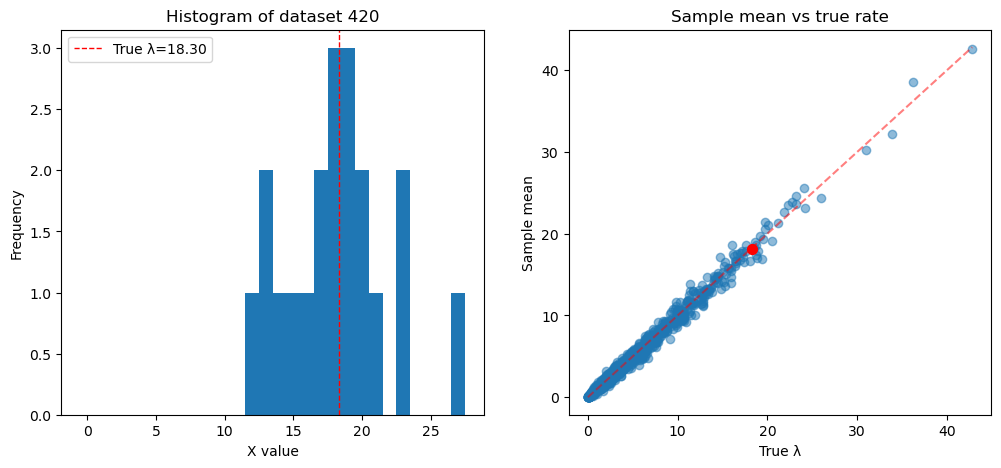

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

a = 1
b = 5
k = 1000 # number of datasets
n = 20 # samples per dataset

np.random.seed(0)

lambdas = np.random.gamma(a, b, size=k)
X = np.random.poisson(lambdas[:, None], size=(k, n))

index_to_plot = 420

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(X[index_to_plot], bins=np.arange(0, X[index_to_plot].max()+2)-0.5)
plt.axvline(lambdas[index_to_plot], color='r', linestyle='dashed', linewidth=1, label=f'True λ={lambdas[index_to_plot]:.2f}')
plt.title(f"Histogram of dataset {index_to_plot}")
plt.xlabel("X value")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(lambdas, np.mean(X, axis=1), alpha=0.5)
plt.plot([0, lambdas.max()], [0, lambdas.max()], 'r--', alpha=0.5)
plt.scatter(lambdas[index_to_plot], np.mean(X[index_to_plot]), color='r', s=50)
plt.xlabel("True λ")
plt.ylabel("Sample mean")
plt.title("Sample mean vs true rate")
plt.show()

## Metropolis-Hastings (MH)

We'll use a normal proposal distribution centered at the current value:
$$
q(\lambda^* \mid \lambda_i) = \mathcal N(\lambda_i, \tau^2)
$$
Since the proposal is symmetric, it cancels out in the acceptance ratio.

Now with log probabilities for numerical stability:
$$
\log p(\lambda \mid x) = (a + S - 1) \log \lambda - (b + n) \lambda + \text{const}
$$

Acceptance rate: 0.87


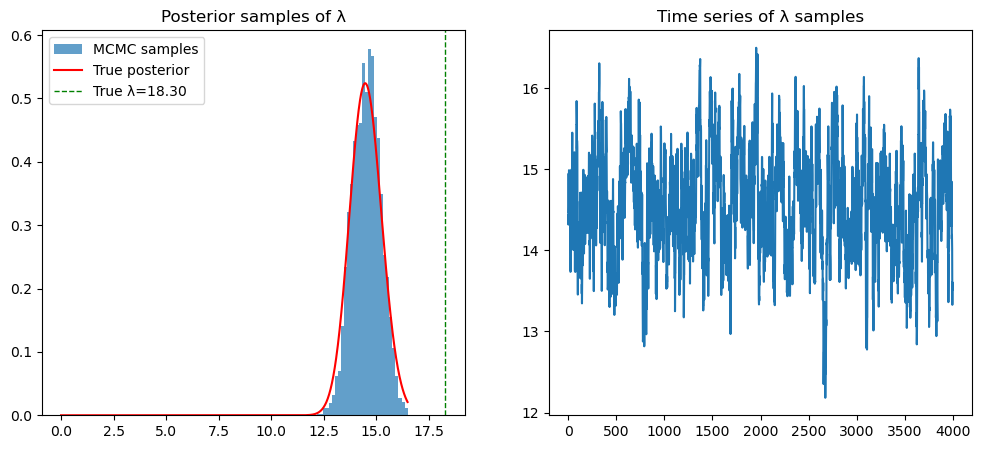

In [18]:
def log_posterior_lambda(lambda_val, S, n, a, b):
    if lambda_val <= 0:
        return -np.inf
    return (a + S - 1) * np.log(lambda_val) - (b + n) * lambda_val

def metropolis_hastings(S, n, a, b, n_samples=5000, tau=0.5, burn_in=1000):
    samples = np.zeros(n_samples)
    
    lambda_current = np.random.gamma(a, 1/b)
    samples[0] = lambda_current
    acceptance_count = 0

    for i in range(1, n_samples):
        lambda_proposal = lambda_current + np.random.normal(0, tau)

        log_p_current = log_posterior_lambda(lambda_current, S, n, a, b)
        log_p_proposal = log_posterior_lambda(lambda_proposal, S, n, a, b)

        log_acceptance_ratio = log_p_proposal - log_p_current
        
        if np.log(np.random.rand()) < log_acceptance_ratio:
            lambda_current = lambda_proposal
            acceptance_count += 1

        samples[i] = lambda_current

    print(f"Acceptance rate: {acceptance_count / n_samples:.2f}")
    return samples[burn_in:]

S = np.sum(X[index_to_plot])

samples_log = metropolis_hastings(S, n, a, b, tau=0.3, burn_in=1000)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(samples_log, bins=30, density=True, alpha=0.7, label='MCMC samples')
x_range = np.linspace(0, samples_log.max(), 1000)
analytical_posterior = stats.gamma.pdf(x_range, a + S, scale=1/(b + n))
plt.plot(x_range, analytical_posterior, 'r-', label='True posterior')
plt.axvline(lambdas[index_to_plot], color='g', linestyle='dashed', linewidth=1, label=f'True λ={lambdas[index_to_plot]:.2f}')
plt.title("Posterior samples of λ")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(samples_log)
plt.title("Time series of λ samples")
plt.show()

## Analytical Posterior Comparison

True λ: 18.2978
Analytical posterior mean: 14.5200
MCMC posterior mean: 14.5535
Analytical posterior std: 0.7621
MCMC posterior std: 0.6744


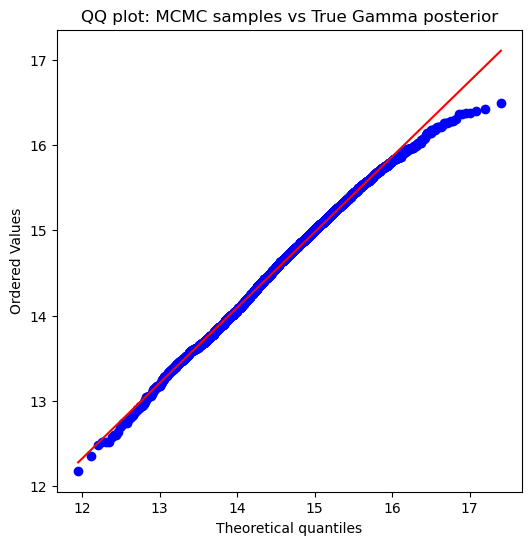

In [19]:
posterior_a = a + S
posterior_b = b + n

# Analytical posterior mean and variance
posterior_mean_analytical = posterior_a / posterior_b
posterior_var_analytical = posterior_a / (posterior_b**2)

# Sample from true posterior
true_posterior_samples = np.random.gamma(posterior_a, 1/posterior_b, size=len(samples_log))

print(f"True λ: {lambdas[index_to_plot]:.4f}")
print(f"Analytical posterior mean: {posterior_mean_analytical:.4f}")
print(f"MCMC posterior mean: {np.mean(samples_log):.4f}")
print(f"Analytical posterior std: {np.sqrt(posterior_var_analytical):.4f}")
print(f"MCMC posterior std: {np.std(samples_log):.4f}")

# QQ plot to compare distributions
plt.figure(figsize=(6, 6))
stats.probplot(samples_log, dist=stats.gamma(posterior_a, scale=1/posterior_b), plot=plt)
plt.title("QQ plot: MCMC samples vs True Gamma posterior")
plt.show()

## Neural Network Inference (posterior mean)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as nnf

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers=2):
        super(MLP, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.nn = nn.Sequential(*layers)

    def forward(self, x):
        return self.nn(x)

For the Poisson distribution, we need to handle discrete count data. We'll use a DeepSets architecture that can handle variable-sized integer inputs.

In [21]:
class PosteriorMeanEstimator(nn.Module):
    def __init__(self,
        summary_stats=32,
        summary_width=32,
        estimator_width=32):
        
        super().__init__()

        self.mlp_point = MLP(
            input_dim=1, 
            output_dim=summary_stats, 
            hidden_dim=summary_width,
            n_layers=2)

        self.mlp_aggregate = MLP(
            input_dim=summary_stats, 
            output_dim=1, 
            hidden_dim=estimator_width,
            n_layers=2)

    def forward(self, x):
        x = x.unsqueeze(-1).float()  # (batch_size, n, 1)
        summaries = self.mlp_point(x)  # (batch_size, n, summary_stats)
        H = summaries.sum(dim=1)  # (batch_size, summary_stats)
        out = self.mlp_aggregate(H)  # (batch_size, 1)
        return nnf.softplus(out.squeeze(-1))

# Test untrained network
input_obs = torch.tensor(X[index_to_plot], dtype=torch.float32).unsqueeze(0)
neural_estimator = PosteriorMeanEstimator()
lambda_hat = neural_estimator(input_obs)

print(f"True λ: {lambdas[index_to_plot]:.2f}")
print(f"Initial λ_hat: {lambda_hat.item():.2f}")

True λ: 18.30
Initial λ_hat: 1.07


### Training

In [22]:
def sample_batch(batch_size, a, b, n):
    lambda_batch = torch.from_numpy(np.random.gamma(a, 1/b, size=batch_size)).float()
    x_batch = torch.zeros(batch_size, n)
    for i in range(batch_size):
        x_batch[i] = torch.from_numpy(np.random.poisson(lambda_batch[i].item(), size=n)).float()
    return lambda_batch, x_batch

# Generate test set
lambda_test, x_test = sample_batch(1024, a, b, n)

loss_fn = torch.nn.MSELoss()
test_output = neural_estimator(x_test)
test_loss = loss_fn(test_output, lambda_test)
print(f"Initial test loss: {test_loss:.4f}")

Initial test loss: 0.2169


Epoch 8/64, Train Loss: 0.0085, Test Loss: 0.0087
Epoch 16/64, Train Loss: 0.0081, Test Loss: 0.0083
Epoch 24/64, Train Loss: 0.0080, Test Loss: 0.0082
Epoch 32/64, Train Loss: 0.0079, Test Loss: 0.0083
Epoch 40/64, Train Loss: 0.0078, Test Loss: 0.0081
Epoch 48/64, Train Loss: 0.0081, Test Loss: 0.0082
Epoch 56/64, Train Loss: 0.0083, Test Loss: 0.0082
Epoch 64/64, Train Loss: 0.0081, Test Loss: 0.0083


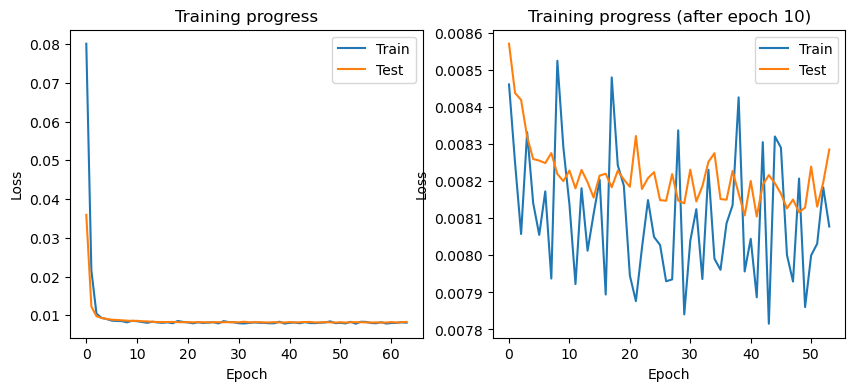

In [23]:
n_epochs = 64
n_batches_per_epoch = 128
training_batch_size = 128

optimizer = torch.optim.Adam(neural_estimator.parameters(), lr=0.0001)

train_losses = []
test_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    
    for batch_idx in range(n_batches_per_epoch):
        lambda_batch, x_batch = sample_batch(training_batch_size, a, b, n)
        
        optimizer.zero_grad()
        lambda_pred = neural_estimator(x_batch)
        loss = loss_fn(lambda_pred, lambda_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / n_batches_per_epoch
    train_losses.append(avg_epoch_loss)
    
    with torch.no_grad():
        lambda_pred_test = neural_estimator(x_test)
        test_loss = loss_fn(lambda_pred_test, lambda_test).item()
        test_losses.append(test_loss)
    
    if (epoch + 1) % 8 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training progress')

plt.subplot(1, 2, 2)
plt.plot(train_losses[10:], label='Train')
plt.plot(test_losses[10:], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training progress (after epoch 10)')
plt.show()

## Comparison: Neural Network vs MCMC vs Analytical

In [24]:
# Generate new test data
lambda_compare, x_compare = sample_batch(256, a, b, n)

# Neural network predictions
with torch.no_grad():
    lambda_nn = neural_estimator(x_compare).numpy()

# MCMC estimates
lambda_mcmc = np.zeros(x_compare.shape[0])
for i in range(x_compare.shape[0]):
    xs = x_compare[i].numpy().astype(int)
    S_i = np.sum(xs)
    samples = metropolis_hastings(S_i, n, a, b, n_samples=2000, tau=0.05, burn_in=500)
    lambda_mcmc[i] = np.mean(samples)

# Analytical posterior means
S_compare = x_compare.sum(dim=1).numpy()
lambda_analytical = (a + S_compare) / (b + n)

lambda_true = lambda_compare.numpy()

Acceptance rate: 0.74
Acceptance rate: 0.88
Acceptance rate: 0.85
Acceptance rate: 0.82
Acceptance rate: 0.73
Acceptance rate: 0.65
Acceptance rate: 0.83
Acceptance rate: 0.81
Acceptance rate: 0.81
Acceptance rate: 0.82
Acceptance rate: 0.69
Acceptance rate: 0.86
Acceptance rate: 0.85
Acceptance rate: 0.67
Acceptance rate: 0.66
Acceptance rate: 0.47
Acceptance rate: 0.85
Acceptance rate: 0.45
Acceptance rate: 0.67
Acceptance rate: 0.91
Acceptance rate: 0.75
Acceptance rate: 0.48
Acceptance rate: 0.87
Acceptance rate: 0.47
Acceptance rate: 0.45
Acceptance rate: 0.75
Acceptance rate: 0.75
Acceptance rate: 0.80
Acceptance rate: 0.42
Acceptance rate: 0.68
Acceptance rate: 0.65
Acceptance rate: 0.67
Acceptance rate: 0.82
Acceptance rate: 0.85
Acceptance rate: 0.83
Acceptance rate: 0.74
Acceptance rate: 0.90
Acceptance rate: 0.67
Acceptance rate: 0.46
Acceptance rate: 0.83
Acceptance rate: 0.47
Acceptance rate: 0.87
Acceptance rate: 0.45
Acceptance rate: 0.88
Acceptance rate: 0.82
Acceptance

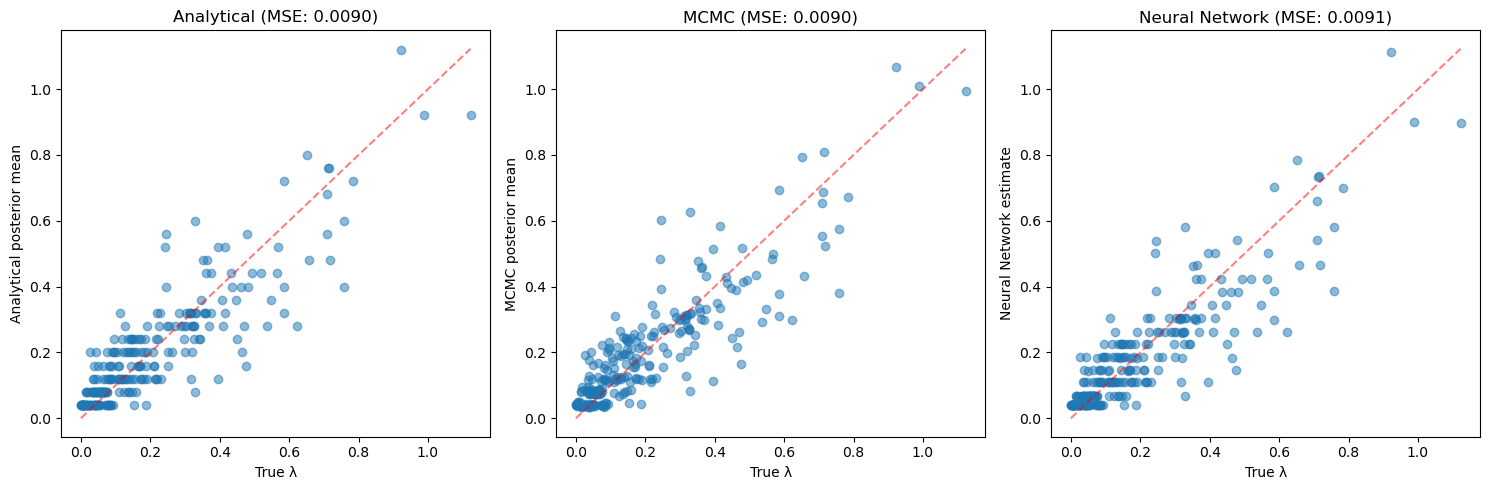

In [25]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(lambda_true, lambda_analytical, alpha=0.5)
plt.plot([0, lambda_true.max()], [0, lambda_true.max()], 'r--', alpha=0.5)
plt.xlabel("True λ")
plt.ylabel("Analytical posterior mean")
plt.title(f"Analytical (MSE: {np.mean((lambda_true - lambda_analytical)**2):.4f})")

plt.subplot(1, 3, 2)
plt.scatter(lambda_true, lambda_mcmc, alpha=0.5)
plt.plot([0, lambda_true.max()], [0, lambda_true.max()], 'r--', alpha=0.5)
plt.xlabel("True λ")
plt.ylabel("MCMC posterior mean")
plt.title(f"MCMC (MSE: {np.mean((lambda_true - lambda_mcmc)**2):.4f})")

plt.subplot(1, 3, 3)
plt.scatter(lambda_true, lambda_nn, alpha=0.5)
plt.plot([0, lambda_true.max()], [0, lambda_true.max()], 'r--', alpha=0.5)
plt.xlabel("True λ")
plt.ylabel("Neural Network estimate")
plt.title(f"Neural Network (MSE: {np.mean((lambda_true - lambda_nn)**2):.4f})")

plt.tight_layout()
plt.show()

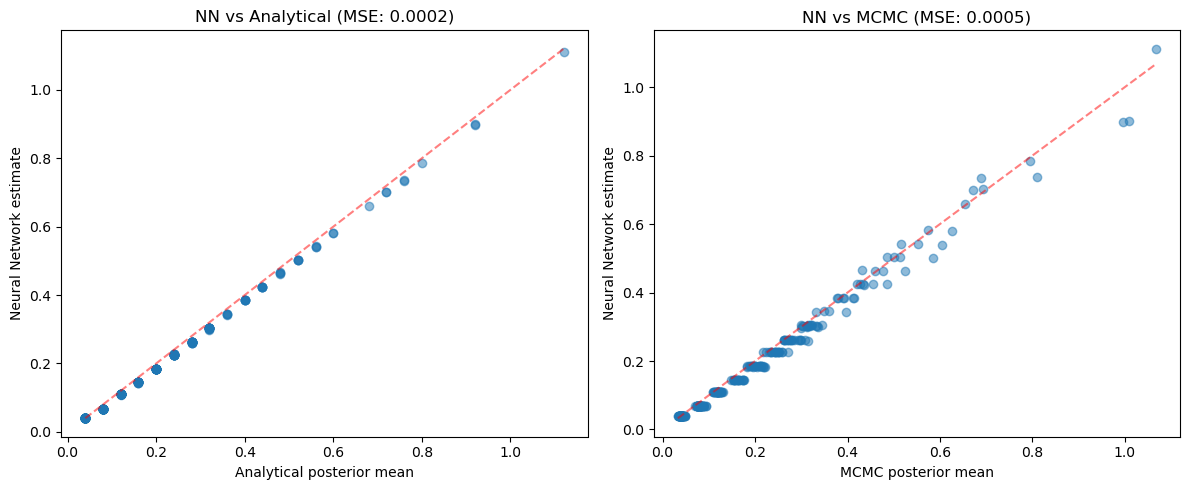

In [26]:
# Compare NN to analytical posterior mean
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(lambda_analytical, lambda_nn, alpha=0.5)
plt.plot([lambda_analytical.min(), lambda_analytical.max()], 
         [lambda_analytical.min(), lambda_analytical.max()], 'r--', alpha=0.5)
plt.xlabel("Analytical posterior mean")
plt.ylabel("Neural Network estimate")
plt.title(f"NN vs Analytical (MSE: {np.mean((lambda_analytical - lambda_nn)**2):.4f})")

plt.subplot(1, 2, 2)
plt.scatter(lambda_mcmc, lambda_nn, alpha=0.5)
plt.plot([lambda_mcmc.min(), lambda_mcmc.max()], 
         [lambda_mcmc.min(), lambda_mcmc.max()], 'r--', alpha=0.5)
plt.xlabel("MCMC posterior mean")
plt.ylabel("Neural Network estimate")
plt.title(f"NN vs MCMC (MSE: {np.mean((lambda_mcmc - lambda_nn)**2):.4f})")

plt.tight_layout()
plt.show()